#Linear Elasticity in 2D

##Introduction

This example provides a demonstration of using PyMKS to compute the linear strain field for a two phase composite material. The example introduces the governing equations of linear elasticity along with the unique boundary conditions required for the MKS. It subsequently demonstrates how to generate data for delta microstructures and then use this data to calibrate the first order MKS influence coefficients for all strain fields. The calibrated influence coefficients are used to predict the strain response for a random microstructure and the results are compared with those from finite element. Finally, the influence coefficients are scaled up and the MKS results are again compared
with the finite element data for a large problem.

PyMKS uses the finite element tool [SfePy](http://sfepy.org) to generate both the strain fields to fit the MKS model and the verification data to evaluate the MKS model's accuracy.

###Elastostatics Equations

For the sake of completeness a description of the  equations of linear elasticity are included. The constitutive equation that describes the linear elastic phenomena is Hook's law.

$$ \sigma_{ij} = C_{ijkl}\varepsilon_{kl} $$

$\sigma$ is the stress, $\varepsilon$ is the strain, and $C$ is the stiffness tensor that relates the stress to the strain fields. For an isotropic material the stiffness tensor can be represented by lower dimension terms which can relate the stress and the strain as follows.

$$ \sigma_{ij} = \lambda \delta_{ij} \varepsilon_{kk} + 2\mu \varepsilon_{ij}  $$

$\lambda$ and $\mu$ are the first and second Lame parameters and can be defined in terms of the Young's modulus $E$ and Poisson's ratio $\nu$ in 2D.

$$ \lambda = \frac{E\nu}{(1-\nu)(1-2\nu)} $$

$$ \mu = \frac{E}{3(1+\nu)} $$


Linear strain is related to displacement using the following equation.

$$ \varepsilon_{ij} = \frac{u_{i,j}+u_{j,i}}{2} $$

We can get an equation that relates displacement and stress by plugging the equation above back into our expression for stress.

$$ \sigma_{ij} = \lambda u_{k,k} + \mu( u_{i,j}+u_{j,i})  $$

The equilibrium equation for elastostatics is defined as

$$ \sigma_{ij,j} = 0 $$

and can be cast in terms of displacement.

$$ \mu u_{i,jj}+(\mu + \lambda)u_{j,ij}=0 $$

In this example, a displacement controlled simulation is used to calculate the strain. The domain is a square box of side $L$ which has an macroscopic strain $\bar{\varepsilon}_{xx}$ imposed.

In general, generateing the calibration data for the MKS requires boundary conditions that are both periodic and displaced, which are quite unusual boundary conditions and are given by,

$$ u(L, y) = u(0, y) + L\bar{\varepsilon}_{xx}$$
$$ u(0, L) = u(0, 0) = 0  $$
$$ u(x, 0) = u(x, L) $$

##Modeling with MKS

###Calibration Data and Delta Microstructures

The first order MKS influence coefficients are all that is needed to compute a strain field of a random microstructure as long as the ratio between the elastic moduli (also known as the contrast) is less than 1.5. If this condition is met we can expect a mean absolute error of 2%  or less when comparing the MKS results with those computed using finite element methods [1]. 

Because we are using distinct phases and the contrast is low enough to only need the first order coefficients, delta microstructures and their strain fields are all that we need to calibrate the first order influence coefficients [2]. 

Here we use the `make_delta_microstructure` function from `pymks.datasets` to create the two delta microstructures needed to calibrate the first order influence coefficients for a two phase microstructure. The `make_delta_microstructure` function uses SfePy to generate the data

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

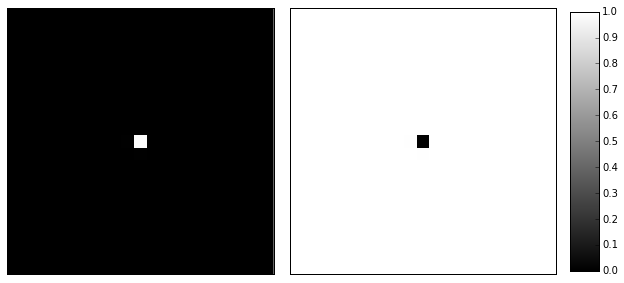

In [2]:
L = 21

from pymks.tools import draw_microstructures
from pymks.datasets import make_delta_microstructures

X_delta = make_delta_microstructures(n_phases=2, size=(L, L))
draw_microstructures(X_delta)

Using delta microstructures for the calibration of the first order influence coefficients is essentially the same as using a unit [impulse response](http://en.wikipedia.org/wiki/Impulse_response) to find the kernel of a system in signal processing. Any given delta microstructure is composed of only two phases with the center cell having an alternative phase from the remainder of the domain. 

###Generating Calibration Data

The `make_elasticFEstrain_delta` function from `pymks.datasets` provides an easy interface to generate delta microstructures and their strain fields, which can then be used for calibration of the influence coefficients. The function calls the `ElasticFESimulation` class to compute the strain fields with the boundary conditions given above.

In this example, lets look at a two phase microstructure with elastic moduli values of 100 and 120 and Poisson's ratio values of 0.3 and 0.3 respectively. Let's also set the macroscopic imposed strain equal to 0.02. All of these parameters used in the simulation must be passed into the `make_elasticFEstrain_delta` function. Note that `make_elasticFEstrain_delta` does not take a number of samples argument as the number of samples to calibrate the MKS is fixed by the number of phases.

In [3]:
from pymks.datasets import make_elastic_FE_strain_delta
from pymks.tools import draw_microstructure_strain

elastic_modulus = (100, 120)
poissons_ratio = (0.3, 0.3)
macro_strain = 0.02
size = (L, L)

X_delta, y_delta = make_elastic_FE_strain_delta(elastic_modulus=elastic_modulus,
                                                poissons_ratio=poissons_ratio,
                                                size=size, macro_strain=macro_strain) 

Let's take a look at one of the delta microstructures and the $\varepsilon_{xx}$ strain field.

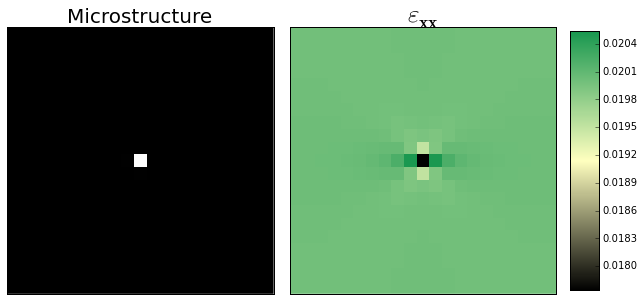

In [4]:
draw_microstructure_strain(X_delta[0], y_delta[0])

###Calibrating First Order Influence Coefficients

Now that we have the delta microstructures and their strain fields, we can calibrate the influence coefficients by creating an instance of the `MKSLocalizationModel` class. Because we have 2 phases we will create an instance of MKSLocalizationModel with the number of states `n_states` equal to 2. Then, pass the delta microstructures and their strain fields to the `fit` method. 

In [5]:
from pymks import MKSLocalizationModel
from pymks import DiscreteIndicatorBasis

basis = DiscreteIndicatorBasis(n_states=2, domain=[0, 1])
MKSmodel = MKSLocalizationModel(basis=basis)

Now, pass the delta microstructures and their strain fields into the `fit` method to calibrate the first order influence coefficients.

In [6]:
MKSmodel.fit(X_delta, y_delta)

That's it, the influence coefficient have be calibrated. Let's take a look at them.

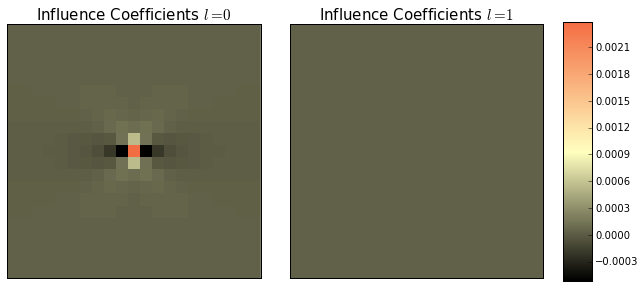

In [7]:
from pymks.tools import draw_coeff

draw_coeff(MKSmodel.coeff)

The influence coefficients for $h=0$ have a Gaussian-like shape, while the influence coefficients for $h=1$ are constant-valued. The constant-valued influence coefficients may seem superfluous, but are equally as import. They are equivalent to the constant term in multiple linear regression with [categorical variables](http://en.wikipedia.org/wiki/Dummy_variable_%28statistics%29).

### Predict the Strain Field for a Random Microstructure

Let's now use our instance of the `MKSLocalizationModel` class with calibrated influence coefficients to compute the strain field for a random two phase microstructure and compare it with the results from a finite element simulation. 

The `make_elasticFEstrain_random` function from `pymks.datasets` is an easy way to generate a random microstructure and its strain field results from finite element analysis.  

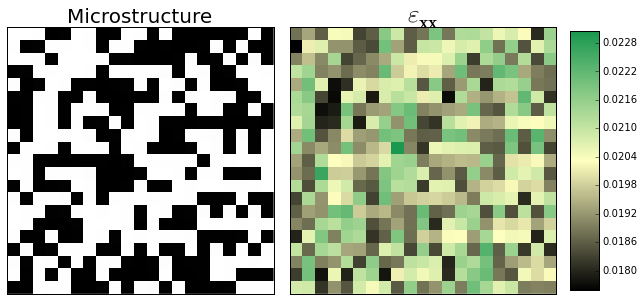

In [8]:
from pymks.datasets import make_elastic_FE_strain_random

np.random.seed(99)
X, strain = make_elastic_FE_strain_random(n_samples=1, elastic_modulus=elastic_modulus,
                                          poissons_ratio=poissons_ratio, size=size, 
                                          macro_strain=macro_strain)
a = draw_microstructure_strain(X[0] , strain[0])

**Note that the calibrated influence coefficients can only be used to reproduce the simulation with the same boundary conditions that they were calibrated with**

Now to get the strain field from the `MKSLocalizationModel` just pass the same microstructure to the `predict` method.

In [9]:
strain_pred = MKSmodel.predict(X)

Finally let's compare the results from finite element simulation and the MKS model.

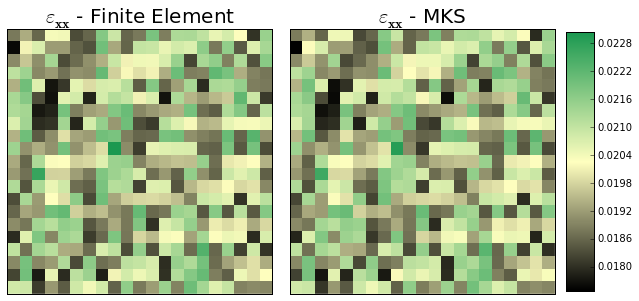

In [10]:
from pymks.tools import draw_strains_compare

draw_strains_compare(strain[0], strain_pred[0])

Lastly, let's look at the difference between the two strain fields.

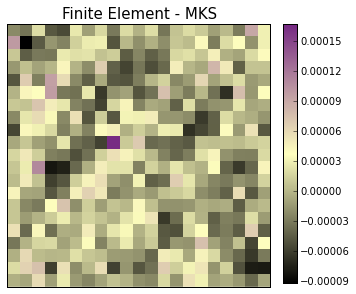

In [11]:
from pymks.tools import draw_differences

draw_differences([strain[0] - strain_pred[0]], ['Finite Element - MKS'])

The MKS model is able to capture the strain field for the random microstructure after being calibrated with delta microstructures.

##Resizing the Coefficients to use on Larger Microstructures 

The influence coefficients that were calibrated on a smaller microstructure can be used to predict the strain field on a larger microstructure though spectral interpolation [3], but accuracy of the MKS model drops slightly. To demonstrate how this is done, let's generate a new larger random microstructure and its strain field.

(63, 63)


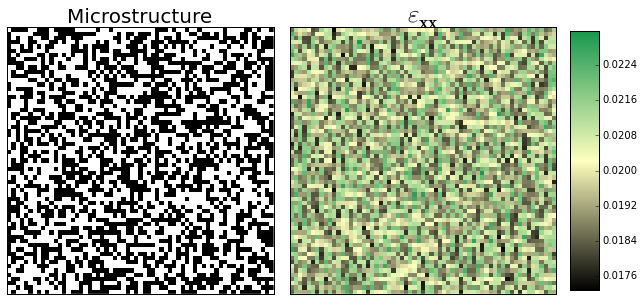

In [12]:
N = 3 * L 
size = (N, N)
print size

X, strain = make_elastic_FE_strain_random(n_samples=1, elastic_modulus=elastic_modulus,
                                          poissons_ratio=poissons_ratio, size=size, 
                                          macro_strain=macro_strain)

draw_microstructure_strain(X[0] , strain[0])

The influence coefficients that have already been calibrated need to be resized to match the shape of the new larger microstructure that we want to compute the strain field for. This can be done by passing the shape of the new larger microstructure into the 'resize_coeff' method.

In [13]:
MKSmodel.resize_coeff(X[0].shape)

Let's now take a look that ther resized influence coefficients.

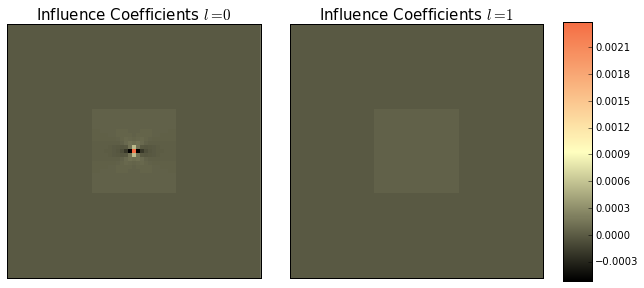

In [14]:
draw_coeff(MKSmodel.coeff)

Because the coefficients have been resized, they will no longer work for our original $L$ by $L$ sized microstructures they were calibrated on, but they can now be used on the $N$ by $N$ microstructures. Just like before, just pass the microstructure as the argument of the `predict` method to get the strain field.

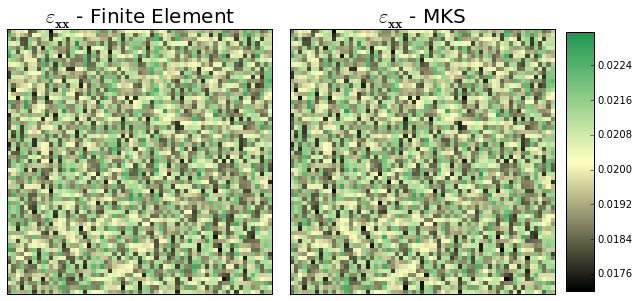

In [15]:
strain_pred = MKSmodel.predict(X)

draw_strains_compare(strain[0], strain_pred[0])

Again, let's look at the difference between the two strain fields.

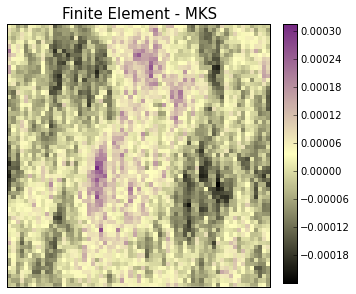

In [20]:
draw_differences([strain[0] - strain_pred[0]], ['Finite Element - MKS'])

As you can see, the results from the strain field computed with the resized influence coefficients is not as close to the finite element results as they were before they were resized. This decrease in accuracy is expected when using spectral interpolation [4].


## References

[1] Binci M., Fullwood D., Kalidindi S.R., A new spectral framework for establishing localization relationships for elastic behavior of composites and their calibration to finite-element models. Acta Materialia, 2008. 56 (10) p. 2272-2282 [doi:10.1016/j.actamat.2008.01.017](http://dx.doi.org/10.1016/j.actamat.2008.01.017).


[2] Landi, G., S.R. Niezgoda, S.R. Kalidindi, Multi-scale modeling of elastic response of three-dimensional voxel-based microstructure datasets using novel DFT-based knowledge systems. Acta Materialia, 2009. 58 (7): p. 2716-2725 [doi:10.1016/j.actamat.2010.01.007](http://dx.doi.org/10.1016/j.actamat.2010.01.007).


[3] Marko, K., Kalidindi S.R., Fullwood D., Computationally efficient database and spectral interpolation for fully plastic Taylor-type crystal plasticity calculations of face-centered cubic polycrystals. International Journal of Plasticity 24 (2008) 1264–1276 [doi;10.1016/j.ijplas.2007.12.002](http://dx.doi.org/10.1016/j.ijplas.2007.12.002).


[4] Marko, K. Al-Harbi H. F. , Kalidindi S.R., Crystal plasticity simulations using discrete Fourier transforms. Acta Materialia 57 (2009) 1777–1784 [doi:10.1016/j.actamat.2008.12.017](http://dx.doi.org/10.1016/j.actamat.2008.12.017).